In [7]:
%%capture
!pip install wordsegment

In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from wordsegment import load, segment

In [ ]:
import re
import emoji
import pandas as pd

# Load data
train_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/train.csv")
dev_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/dev.csv")
df = pd.concat([train_df, dev_df], ignore_index=True)
load()

# -------------------------------
# Text Preprocessing
# -------------------------------

def preprocess_text(text):
    # Extract hashtags
    hashtags = re.findall(r"#\w+", text)

    # Process hashtags (convert to words)
    processed_hashtags = []
    for tag in hashtags:
        tag = tag.lstrip("#")  # Remove #
        words = segment(tag)   # Split compound words
        processed_hashtags.append(" ".join(words))  # Convert to sentence-like format

    # Remove hashtags from main text
    text = re.sub(r"#\w+", "", text)

    # Replace mentions with a placeholder
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))  # Adds spaces around emoji descriptions
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Merge cleaned text with processed hashtags
    final_text = text + " " + " ".join(processed_hashtags)

    return final_text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Show sample processed data
df.sample(10)

,text,label
4916,எண் கோட்ராவில் தேய் ஓதா மார்வாடி,1
3527,அண்ணன் சீமான் விதைத்த விதைகள் இன்று முளைவிட்டு...,0
2204,என் உயிா் தம்பி சீமான் சின்னம் நமக்கு கிடைத்து...,1
4110,S K நான் சொன்னது எந்த அரசாக இருந்தாலும் மக்கள ...,1
6853,<USER> எந்தகுடிலேருந்து வந்தது தமிழ்சாதிகள்,0
5580,சகோதரர் அவுனுவல் வெறும் முட்டாள்கள் கூட்டம்......,1
3671,Thank for sharing the video Madrasi Anna’s fol...,0
1609,தமிழ் நாட்டுக்குதேனவ இல்ல அப்படியேபோகட்டும்,1
1193,​ <USER> ne muslim or christian ah ilala hindu...,0
5753,90 சதவீதம் பேர் வடக்கிலிருந்து பீகார் மற்றும் ...,1


In [10]:
texts = df['text'].tolist()
labels = df['label'].tolist()
len(texts), len(labels)

(7197, 7197)

In [11]:
from transformers import AutoTokenizer, AutoModel

# Load the MurIL tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('google/muril-large-cased')
model = AutoModel.from_pretrained('google/muril-large-cased')

# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(197285, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1,

In [12]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenized_data = tokenize_texts(texts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_data['input_ids'][idx],
            'attention_mask': self.tokenized_data['attention_mask'][idx],
            'label': self.labels[idx]
        }

dataset = TextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [14]:
all_embeddings = []
# Forward pass
with torch.no_grad():
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.append(cls_embeddings.cpu())
        
X = torch.cat(all_embeddings).numpy()
y = np.array(labels)

# Save embeddings
np.save("/kaggle/working/muril_large_embeddings_after_aug.npy", X)

In [16]:
from IPython.display import FileLink

FileLink("muril_large_embeddings_after_aug.npy")

/kaggle/working/muril_large_embeddings_after_aug.npy

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='rbf'),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=5),
    GradientBoostingClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    LGBMClassifier()
]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Naive Bayes', 'KNN', 'Gradient Boosting', 'XGBoost', 'LightGBM']

results = {}

for model, name in zip(models, model_names):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')  # <-- Macro F1
    cm = confusion_matrix(y_val, y_pred)
    
    results[name] = {
        'Model': model,
        'Accuracy': acc,
        'Macro F1 Score': f1_macro,
        'Confusion Matrix': cm
    }
    
    print(f"{name} -> Accuracy: {acc:.4f}, Macro F1 Score: {f1_macro:.4f}")
    print("Confusion Matrix:\n", cm)
    print("-" * 50)

Logistic Regression -> Accuracy: 0.6921, Macro F1 Score: 0.6428
Confusion Matrix:
 [[670 128]
 [260 202]]
--------------------------------------------------
Random Forest -> Accuracy: 0.7738, Macro F1 Score: 0.7276
Confusion Matrix:
 [[747  51]
 [234 228]]
--------------------------------------------------
SVM -> Accuracy: 0.7127, Macro F1 Score: 0.6469
Confusion Matrix:
 [[721  77]
 [285 177]]
--------------------------------------------------
Naive Bayes -> Accuracy: 0.6063, Macro F1 Score: 0.5335
Confusion Matrix:
 [[631 167]
 [329 133]]
--------------------------------------------------
KNN -> Accuracy: 0.6421, Macro F1 Score: 0.6108
Confusion Matrix:
 [[583 215]
 [236 226]]
--------------------------------------------------
Gradient Boosting -> Accuracy: 0.7246, Macro F1 Score: 0.6662
Confusion Matrix:
 [[720  78]
 [269 193]]
--------------------------------------------------
XGBoost -> Accuracy: 0.7722, Macro F1 Score: 0.7411
Confusion Matrix:
 [[705  93]
 [194 268]]
------------

In [12]:
voting_clf = VotingClassifier(estimators=[
    ('rf', models[1]), ('xgb', models[6]), ('lgbm', models[7])], voting='hard')
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_val_scaled)
acc_voting = accuracy_score(y_val, y_pred_voting)
f1_voting = f1_score(y_val, y_pred_voting, average='macro')
cm_voting = confusion_matrix(y_val, y_pred_voting)

results['Voting Classifier'] = {
    'Model': voting_clf,
    'Accuracy': acc_voting,
    'Macro F1 Score': f1_voting,
    'Confusion Matrix': cm_voting
}

stacking_clf = StackingClassifier(
    estimators=[('rf', models[1]), ('xgb', models[6]), ('lgbm', models[7])],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_val_scaled)
acc_stacking = accuracy_score(y_val, y_pred_stacking)
f1_stacking = f1_score(y_val, y_pred_stacking, average='macro')
cm_stacking = confusion_matrix(y_val, y_pred_stacking)

results['Stacking Classifier'] = {
    'Model': stacking_clf,
    'Accuracy': acc_stacking,
    'Macro F1 Score': f1_stacking,
    'Confusion Matrix': cm_stacking
}

[LightGBM] [Info] Number of positive: 1937, number of negative: 3102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384402 -> initscore=-0.470907
[LightGBM] [Info] Start training from score -0.470907
[LightGBM] [Info] Number of positive: 1937, number of negative: 3102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384402 -> initscore=-0.470907
[LightGBM] [Info] Start training from score -0.470907
[LightGBM] [

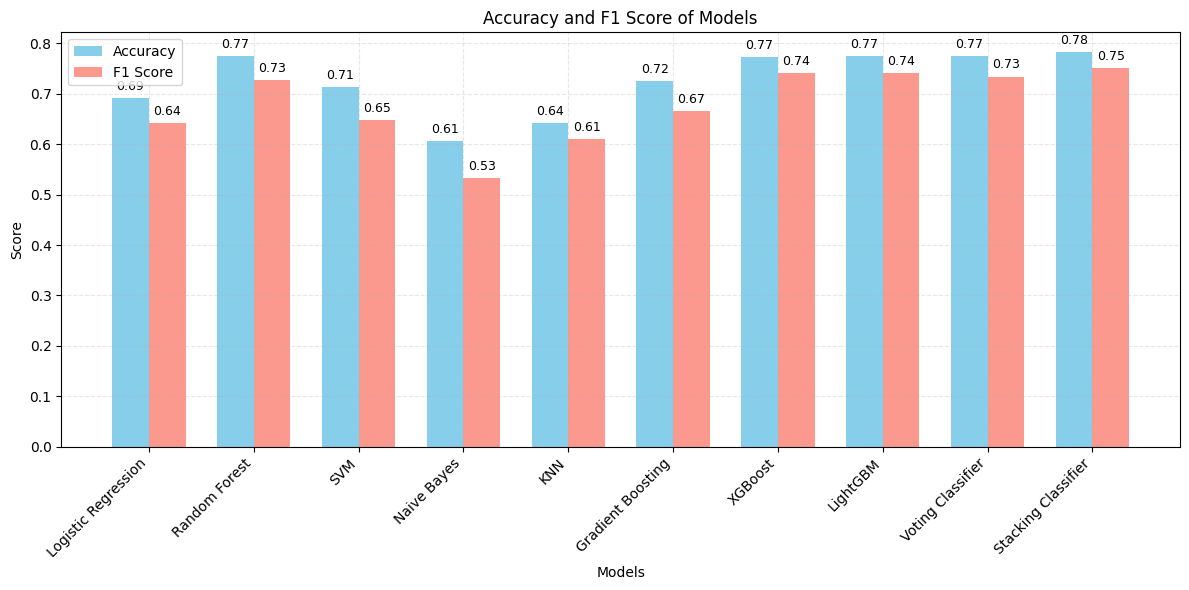


Confusion Matrix for Logistic Regression:
[[670 128]
 [260 202]]


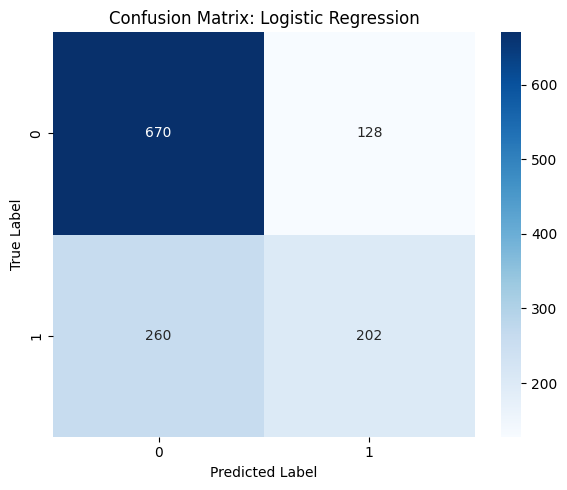


Confusion Matrix for Random Forest:
[[747  51]
 [234 228]]


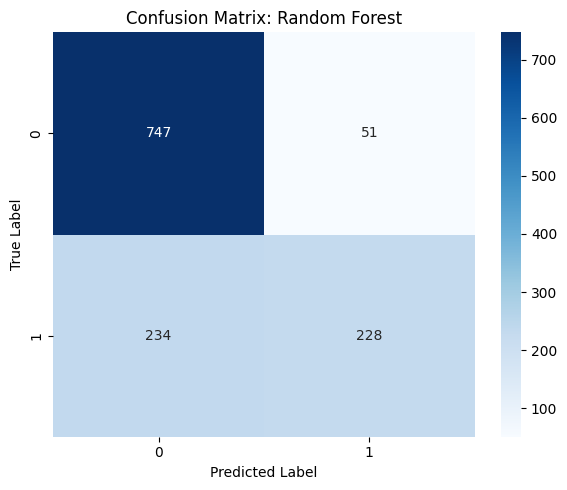


Confusion Matrix for SVM:
[[721  77]
 [285 177]]


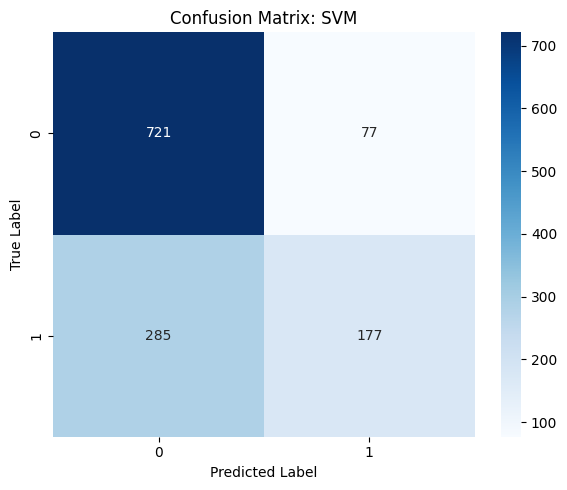


Confusion Matrix for Naive Bayes:
[[631 167]
 [329 133]]


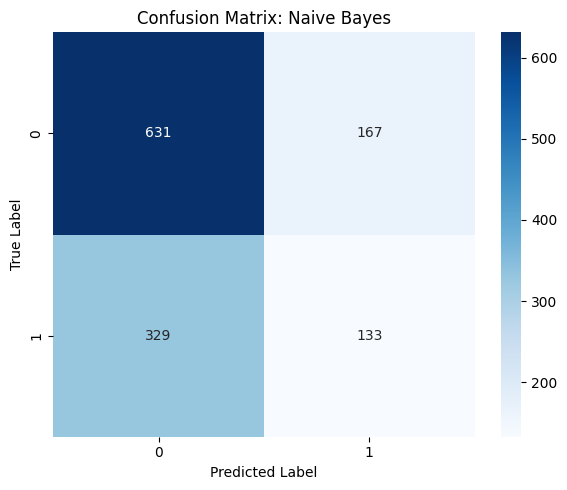


Confusion Matrix for KNN:
[[583 215]
 [236 226]]


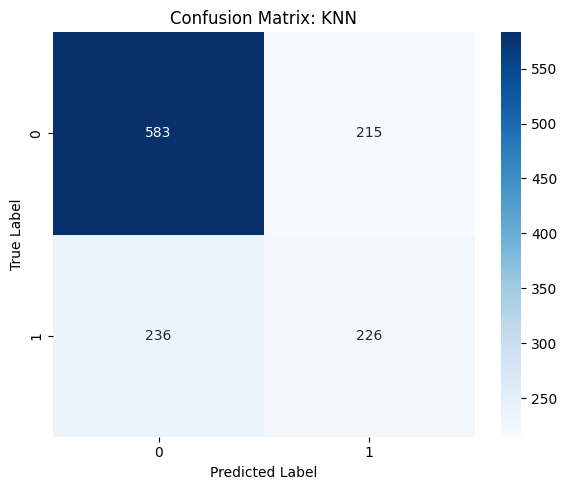


Confusion Matrix for Gradient Boosting:
[[720  78]
 [269 193]]


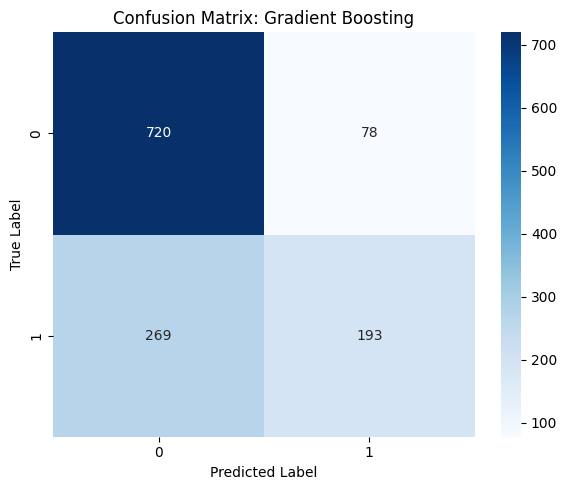


Confusion Matrix for XGBoost:
[[705  93]
 [194 268]]


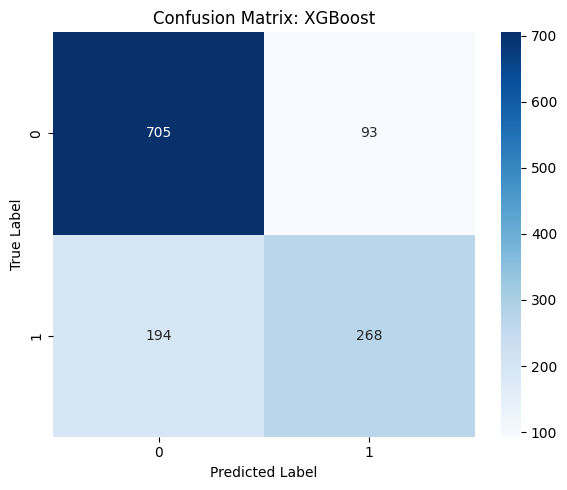


Confusion Matrix for LightGBM:
[[713  85]
 [200 262]]


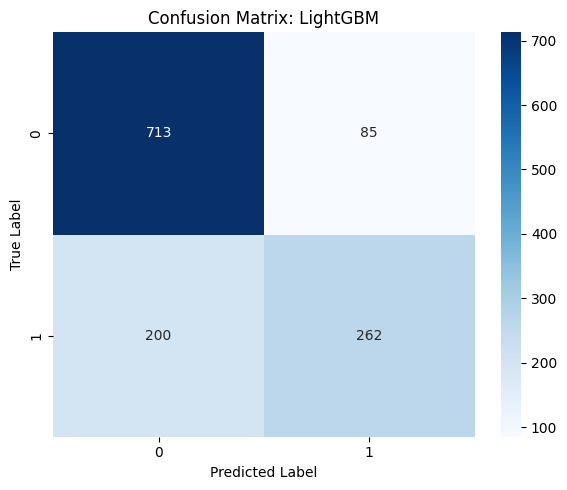


Confusion Matrix for Voting Classifier:
[[734  64]
 [220 242]]


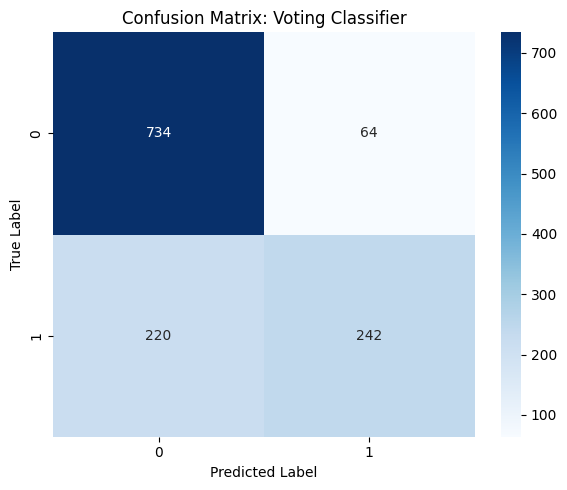


Confusion Matrix for Stacking Classifier:
[[717  81]
 [193 269]]


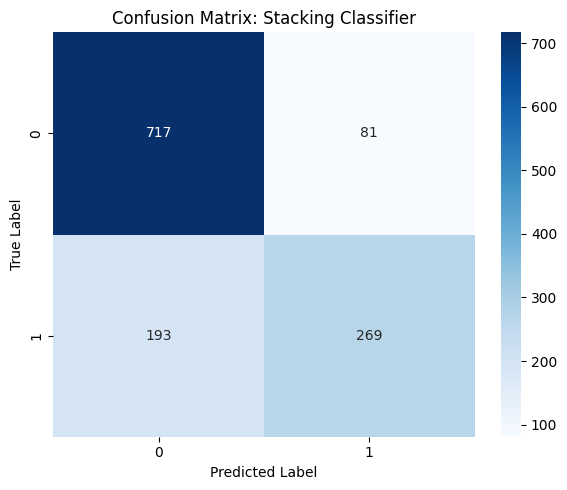

In [13]:
model_labels = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_labels]
f1_scores = [results[m]['Macro F1 Score'] for m in model_labels]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_labels))
bar_width = 0.35

bars1 = ax.bar(x - bar_width/2, accuracies, bar_width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + bar_width/2, f1_scores, bar_width, label='F1 Score', color='salmon', alpha=0.8)

# Annotate bars with values on top
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Accuracy and F1 Score of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# ==========================
# Plot Confusion Matrices
# ==========================
for model_name in model_labels:
    print(f"\nConfusion Matrix for {model_name}:")
    cm = results[model_name]['Confusion Matrix']
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()